In [1]:
import pandas as pd

In [2]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet 

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fe494bd3f520a5ee42d956239f8e72c898eb6fbd5618705b01e31f0d6b91afe4
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
!pip install -q --upgrade fastcore fastai
!pip install --upgrade torch

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [4]:
import random 
import numpy as np
import torch
    
def random_seed(dls,seed_value):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    dls.rng.seed(seed_value)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [5]:
from fastai.vision.all import *
pd.options.mode.chained_assignment = None
train = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Train.csv')
test = pd.read_csv('../input/csv-files-for-microsoft-rice-disease/Test.csv')
submission = pd.read_csv("../input/csv-files-for-microsoft-rice-disease/SampleSubmission.csv")

In [6]:
train

,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast
...,...,...
5335,id_zz6gzk7p97_rgn.jpg,brown
5336,id_zz8ca2p67e.jpg,blast
5337,id_zz8ca2p67e_rgn.jpg,blast
5338,id_zzt8y9q0x0.jpg,brown


In [7]:
unique_label = train['Label'].unique()
unique_label

array(['blast', 'brown', 'healthy'], dtype=object)

In [8]:
train['Label'].value_counts()

blast      2988
brown      1532
healthy     820
Name: Label, dtype: int64

In [9]:
train = train[~train.Image_id.str.contains('_rgn')]
train.reset_index(inplace=True,drop=True)
test = test[~test.Image_id.str.contains('_rgn')]
test.reset_index(inplace=True,drop=True)

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['Label']=le.fit_transform(train['Label'])

In [11]:
img=Image.open('../input/microsoft-rice-disease-classification-challenge/id_004wknd7qd_rgn.jpg') # View one image and check the files are present
img.shape

(1500, 2000)

In [12]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()
import gc; gc.collect()

133

In [13]:
!nvidia-smi

Sat Jun 11 10:40:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
!pip install timm
from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 KB 697.6 kB/s eta 0:00:00


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.449264,0.257072,0.078652,0.921348,05:19


Better model found at epoch 0 with valid_loss value: 0.2570720314979553.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.285871,0.196237,0.069288,0.930712,05:21
1,0.225487,0.156537,0.063670,0.936330,05:21
2,0.211283,0.136751,0.050562,0.949438,05:21
3,0.156795,0.120233,0.050562,0.949438,05:21
4,0.144458,0.092388,0.029963,0.970037,05:21
5,0.084509,0.119639,0.041199,0.958802,05:21
6,0.091866,0.111341,0.033708,0.966292,05:22
7,0.075633,0.068702,0.022472,0.977528,05:22
8,0.059676,0.071996,0.020599,0.979401,05:21
9,0.090643,0.101031,0.035581,0.964419,05:22


Better model found at epoch 0 with valid_loss value: 0.1962365210056305.
Better model found at epoch 1 with valid_loss value: 0.1565372496843338.
Better model found at epoch 2 with valid_loss value: 0.13675080239772797.
Better model found at epoch 3 with valid_loss value: 0.12023250013589859.
Better model found at epoch 4 with valid_loss value: 0.09238844364881516.
Better model found at epoch 7 with valid_loss value: 0.06870204955339432.
Better model found at epoch 11 with valid_loss value: 0.06114393100142479.


0.055498897888639265


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.473062,0.452837,0.177903,0.822097,05:21


Better model found at epoch 0 with valid_loss value: 0.45283713936805725.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.300348,0.250379,0.082397,0.917603,05:22
1,0.232791,0.208746,0.082397,0.917603,05:22
2,0.202042,0.157869,0.056180,0.943820,05:22
3,0.132419,0.148517,0.054307,0.945693,05:20
4,0.126238,0.122299,0.039326,0.960674,05:21
5,0.109336,0.122701,0.041199,0.958802,05:21
6,0.089740,0.134561,0.046816,0.953184,05:21
7,0.053350,0.073679,0.020599,0.979401,05:22
8,0.064626,0.062388,0.024345,0.975655,05:23
9,0.053128,0.070709,0.020599,0.979401,05:21


Better model found at epoch 0 with valid_loss value: 0.25037893652915955.
Better model found at epoch 1 with valid_loss value: 0.20874623954296112.
Better model found at epoch 2 with valid_loss value: 0.15786901116371155.
Better model found at epoch 3 with valid_loss value: 0.1485167145729065.
Better model found at epoch 4 with valid_loss value: 0.12229899317026138.
Better model found at epoch 7 with valid_loss value: 0.07367932796478271.
Better model found at epoch 8 with valid_loss value: 0.06238812208175659.
Better model found at epoch 11 with valid_loss value: 0.06223775073885918.
Better model found at epoch 13 with valid_loss value: 0.05525321513414383.


0.05904018770900363


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.426805,0.384286,0.132959,0.867041,05:21


Better model found at epoch 0 with valid_loss value: 0.3842856287956238.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.181080,0.206136,0.067416,0.932584,05:21
1,0.106609,0.153685,0.043071,0.956929,05:21
2,0.099741,0.148744,0.044944,0.955056,05:21
3,0.089301,0.168883,0.035581,0.964419,05:21
4,0.103612,0.160395,0.035581,0.964419,05:21
5,0.072483,0.223269,0.056180,0.943820,05:21
6,0.037997,0.126426,0.028090,0.971910,05:21
7,0.023630,0.149396,0.024345,0.975655,05:21
8,0.024319,0.184533,0.037453,0.962547,05:21
9,0.012462,0.204089,0.035581,0.964419,05:21


Better model found at epoch 0 with valid_loss value: 0.20613619685173035.
Better model found at epoch 1 with valid_loss value: 0.15368546545505524.
Better model found at epoch 2 with valid_loss value: 0.14874380826950073.
Better model found at epoch 6 with valid_loss value: 0.12642638385295868.


0.1274632299162415


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.430223,0.387481,0.157303,0.842697,05:21


Better model found at epoch 0 with valid_loss value: 0.38748133182525635.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.147248,0.163153,0.065543,0.934457,05:21
1,0.150280,0.164830,0.059925,0.940075,05:21
2,0.151820,0.276822,0.108614,0.891386,05:21
3,0.100036,0.161020,0.058052,0.941948,05:21
4,0.103399,0.306874,0.101124,0.898876,05:21
5,0.134148,0.097766,0.039326,0.960674,05:21
6,0.048795,0.126181,0.039326,0.960674,05:21
7,0.078756,0.108113,0.039326,0.960674,05:21
8,0.068282,0.157498,0.054307,0.945693,05:21
9,0.037125,0.101153,0.031835,0.968165,05:21


Better model found at epoch 0 with valid_loss value: 0.16315282881259918.
Better model found at epoch 3 with valid_loss value: 0.1610199362039566.
Better model found at epoch 5 with valid_loss value: 0.09776642173528671.
Better model found at epoch 15 with valid_loss value: 0.07948753982782364.
Better model found at epoch 18 with valid_loss value: 0.07696528732776642.


0.06425615800276391


fold fineshed


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.613611,0.341670,0.131086,0.868914,05:22


Better model found at epoch 0 with valid_loss value: 0.34166955947875977.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.219683,0.194786,0.063670,0.936330,05:21
1,0.151429,0.383031,0.132959,0.867041,05:22
2,0.176837,0.172449,0.054307,0.945693,05:22
3,0.192607,0.146729,0.044944,0.955056,05:22
4,0.174543,0.198221,0.065543,0.934457,05:23
5,0.176213,0.186229,0.058052,0.941948,05:23
6,0.125493,0.154663,0.044944,0.955056,05:23
7,0.133016,0.236613,0.082397,0.917603,05:23
8,0.106351,0.118206,0.043071,0.956929,05:22
9,0.111343,0.207960,0.069288,0.930712,05:22


Better model found at epoch 0 with valid_loss value: 0.19478556513786316.
Better model found at epoch 2 with valid_loss value: 0.17244930565357208.
Better model found at epoch 3 with valid_loss value: 0.14672869443893433.
Better model found at epoch 8 with valid_loss value: 0.11820570379495621.


0.10382438535347947


fold fineshed


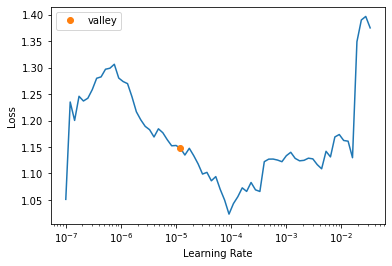

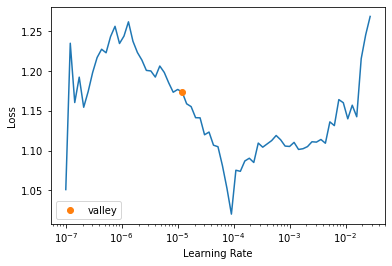

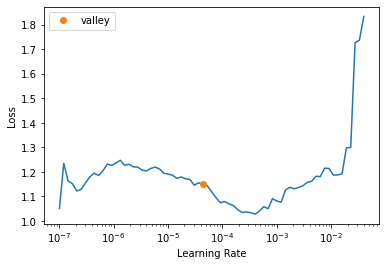

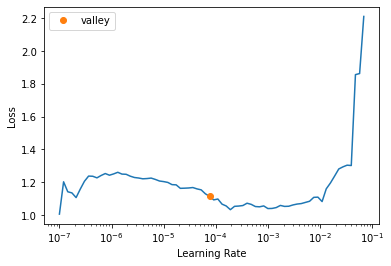

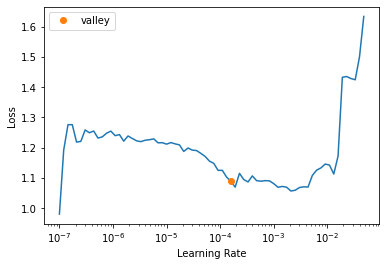

In [15]:
from sklearn.model_selection import StratifiedKFold
from fastai.callback.tracker import SaveModelCallback,EarlyStoppingCallback
import sklearn
from sklearn.metrics import log_loss
tfms = aug_transforms(do_flip = True, flip_vert = False, mult=2.0,size=384)
skf=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
y_pred_tot=[]
valid_loglos=[]
i=0
oof = np.zeros((train.shape[0],3))
for train_index, test_index in skf.split(train, train['Label']): 
    train['val_col']=False
    train.loc[test_index,'val_col']=True
    dls = ImageDataLoaders.from_df(train, path='../input/microsoft-rice-disease-classification-challenge',item_tfms=Resize(384),batch_tfms=[*tfms,Normalize.from_stats(*imagenet_stats)],valid_col='val_col',seed=50,num_workers=1,val_pct=0,bs=4)
    random_seed(dls,50)
    #model = EfficientNet.from_pretrained("efficientnet-b7")
    #model._fc = nn.Linear(model._fc.in_features,3)
    model = create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=3)
    learn = Learner(dls,model,metrics=[error_rate,accuracy],path='.',cbs=[SaveModelCallback(monitor='valid_loss')])
#         learn = cnn_learner(dls,vgg19_bn,metrics=[error_rate,accuracy],path='.',cbs=[EarlyStoppingCallback(monitor='valid_loss',min_delta=0.001, patience=10),SaveModelCallback(monitor='valid_loss')])
    random_seed(dls,50)
    best_lr = learn.lr_find()
    learn.fine_tune(20,best_lr.valley)
    #val
    valid =learn.dls.test_dl(train.iloc[test_index]['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    val_preds = learn.get_preds(dl=valid)
    print(log_loss(train.iloc[test_index]['Label'],val_preds[0]))
    oof[test_index]=val_preds[0]
    #test
    tdl = learn.dls.test_dl(test['Image_id'].map(lambda s: '../input/microsoft-rice-disease-classification-challenge/'+s).values)
    learn.save("model"+str(i))
    preds = learn.get_preds(dl=tdl)
    y_pred_tot.append(preds)
    print('fold fineshed')
    i=i+1

In [16]:
from sklearn.metrics import log_loss
log_loss(train['Label'].values,oof)

0.08201657980457178

In [17]:
predss=[to_np(x[0])for x in y_pred_tot]
predss


[array([[9.9999976e-01, 4.6847241e-08, 2.7565073e-07],
        [1.4974238e-02, 9.8502058e-01, 5.1891184e-06],
        [9.9197292e-01, 8.0147646e-03, 1.2356300e-05],
        ...,
        [9.9986768e-01, 1.3232716e-04, 2.2548257e-09],
        [9.9995601e-01, 1.1411120e-05, 3.2579195e-05],
        [1.4046719e-03, 6.0675742e-05, 9.9853468e-01]], dtype=float32),
 array([[9.9999988e-01, 4.0167563e-08, 1.0524448e-07],
        [2.3681711e-01, 7.6313078e-01, 5.2169562e-05],
        [9.9213219e-01, 7.7920933e-03, 7.5755030e-05],
        ...,
        [9.9943715e-01, 5.6281884e-04, 3.1344465e-09],
        [9.9999678e-01, 6.2738496e-07, 2.6377027e-06],
        [4.3689664e-03, 4.8807879e-06, 9.9562615e-01]], dtype=float32),
 array([[9.9999952e-01, 2.1153916e-07, 3.1404150e-07],
        [4.5601708e-01, 5.4198462e-01, 1.9983561e-03],
        [9.8741102e-01, 1.2266656e-02, 3.2232516e-04],
        ...,
        [9.9987531e-01, 1.2442142e-04, 2.9962587e-07],
        [9.9999475e-01, 2.3036912e-06, 2.966948

In [18]:
preds=np.mean(predss,0)
preds

array([[9.99992013e-01, 7.75744593e-06, 2.43510328e-07],
       [1.41744405e-01, 8.57833564e-01, 4.21985111e-04],
       [9.86336350e-01, 1.34136155e-02, 2.50023004e-04],
       ...,
       [9.51897025e-01, 4.80808578e-02, 2.20870879e-05],
       [9.99958634e-01, 3.31663650e-05, 8.25154166e-06],
       [1.86606478e-02, 9.93942725e-04, 9.80345428e-01]], dtype=float32)

In [19]:
submission_from_test = test[['Image_id']]
submission_from_test

,Image_id
0,id_00vl5wvxq3.jpg
1,id_01hu05mtch.jpg
2,id_030ln10ewn.jpg
3,id_03z57m8xht.jpg
4,id_04ngep1w4b.jpg
...,...
1140,id_zrdlgjrq3r.jpg
1141,id_zsfayxwipp.jpg
1142,id_ztvp2l9k3h.jpg
1143,id_zwwcma7hlt.jpg


In [20]:
le.inverse_transform([0,1,2])

array(['blast', 'brown', 'healthy'], dtype=object)

In [21]:
submission_from_test['blast'] = preds[:,0]
submission_from_test['brown'] = preds[:,1]
submission_from_test['healthy'] = preds[:,2]

In [22]:
submission_from_test

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999992,7.757446e-06,2.435103e-07
1,id_01hu05mtch.jpg,0.141744,8.578336e-01,4.219851e-04
2,id_030ln10ewn.jpg,0.986336,1.341362e-02,2.500230e-04
3,id_03z57m8xht.jpg,1.000000,2.506917e-07,3.869648e-08
4,id_04ngep1w4b.jpg,0.999017,2.626616e-04,7.204509e-04
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,0.000084,3.092706e-02,9.689886e-01
1141,id_zsfayxwipp.jpg,0.000060,9.996690e-01,2.706031e-04
1142,id_ztvp2l9k3h.jpg,0.951897,4.808086e-02,2.208709e-05
1143,id_zwwcma7hlt.jpg,0.999959,3.316637e-05,8.251542e-06


In [23]:
submission_from_test.to_csv("submit_test0.0875_0.0449.csv",index=False)

In [24]:
np.save('y_pred_tot.npy', y_pred_tot, allow_pickle=True)

/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'TensorImage' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'TensorImage', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/opt/conda/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [25]:
submission


,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0
...,...,...,...,...
1140,id_zrdlgjrq3r.jpg,0.0,0.0,0.0
1141,id_zsfayxwipp.jpg,0.0,0.0,0.0
1142,id_ztvp2l9k3h.jpg,0.0,0.0,0.0
1143,id_zwwcma7hlt.jpg,0.0,0.0,0.0
